In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data loading and Pre- Processing

In [59]:
# Housekeeping
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [60]:
#defining the dataset path and directories
base_path = 'dataset/chest_xray'
dir_train = os.path.join(base_path, 'train') #for training data
dir_val = os.path.join(base_path, 'val')# for validation data
dir_test = os.path.join(base_path, 'test') #for test data


In [62]:
# Function to remove corrupted images
def remove_corrupted_images(directory):
    removed_files = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            try:
                with Image.open(filepath) as img:
                    img.verify()  # Verify if the image is corrupted
            except (IOError, SyntaxError):
                os.remove(filepath)  # Remove the corrupted image
                removed_files.append(filepath)

    return removed_files

In [63]:
# Removing corrupted images from each directory
remove_corrupted_images(dir_train)
remove_corrupted_images(dir_val)
remove_corrupted_images(dir_test)

[]

In [64]:
# Now, defining our image data generator with preprocessing

#augumentation
train_dataGen = ImageDataGenerator(
    rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
    zoom_range=0.2, horizontal_flip= True)


# No Augumentation for test
test_dataGen = ImageDataGenerator(rescale=1./255)

#loading imgages from the directories
train_Gen = train_dataGen.flow_from_directory(dir_train, target_size=(150,150), batch_size=20, class_mode='binary')

valid_Gen = test_dataGen.flow_from_directory(dir_val, target_size=(150,150), batch_size=20, class_mode='binary')

test_Gen = test_dataGen.flow_from_directory(dir_test, target_size=(150,150), batch_size=20, class_mode='binary')



Found 5215 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
%pip install Pillow
from PIL import Image
import os

# checking if there is any bad images in all the directories that need to be taken out.
def check_badimages(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check for an appropriate image file extension before proceeding
            if file.lower().endswith(('jpg', 'jpeg', 'png')):  # Ensuring case-insensitive comparison
                path = os.path.join(root, file)
                try:
                    img = Image.open(path)  # Opening the image file
                    img.verify()  #check if its an image
                except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                    print('Bad file:', path)  # Printing the names of corrupt files


# usage
check_badimages(dir_train)
check_badimages(dir_test)
check_badimages(dir_val)


Note: you may need to restart the kernel to use updated packages.
Bad file: dataset/chest_xray\train\NORMAL\NORMAL2-IM-1178-0001.jpeg


# DenseNet

## Model Building

This employs DenseNet121 as the feature extractor, incorporates custom dense layers, and designates the pre-trained model layers as non-trainable to retain the acquired features.

In [77]:
from tensorflow.keras.applications import DenseNet121 as DN
from tensorflow.keras import layers, models

#now we will be loading the pre=trained DenseNet
base_dense_mod = DN(include_top=False, weights='imagenet', input_shape=(150, 150,3))

#customized layers
x = base_dense_mod.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256,activation='relu')(x)
predict = layers.Dense(1, activation= 'sigmoid')(x)

dense_base_model = models.Model(inputs= base_dense_mod.input, outputs= predict)

# freezing the base model layers
for layer in base_dense_mod.layers:
    layer.trainable = False

## Model Compilation

Here, the accuracy metric, binary cross-entropy loss function (fit for binary classification tasks), and Adam optimizer are used to create the model.




In [78]:
"""Defining the optimizer, loss function, and metrics"""

from tensorflow.keras.optimizers import Adam

dense_base_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics= ['accuracy'])


## Training

By iterating over batches of images, the model is trained for 25 epochs, and its performance is verified on the validation set.



In [79]:
# Training the model using the training and validation data

hist = dense_base_model.fit(train_Gen, steps_per_epoch=10, epochs=25,validation_data=valid_Gen, validation_steps=50)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 945ms/step - accuracy: 0.6542 - loss: 1.0376 - val_accuracy: 0.6250 - val_loss: 0.3469
Epoch 2/25


c:\Users\Ananya\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 574ms/step - accuracy: 0.8373 - loss: 0.4188 - val_accuracy: 0.8750 - val_loss: 0.1722
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 551ms/step - accuracy: 0.9033 - loss: 0.2732 - val_accuracy: 0.6875 - val_loss: 0.2879
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 524ms/step - accuracy: 0.9044 - loss: 0.2055 - val_accuracy: 0.6875 - val_loss: 0.3501
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step - accuracy: 0.8417 - loss: 0.3036 - val_accuracy: 0.8125 - val_loss: 0.2117
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 512ms/step - accuracy: 0.9083 - loss: 0.1968 - val_accuracy: 0.6875 - val_loss: 0.3904
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 520ms/step - accuracy: 0.9043 - loss: 0.2005 - val_accuracy: 0.6875 - val_loss: 0.4564
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 511ms/step - accuracy: 0.8902 - loss: 0.2409 - val_accuracy: 0.6875 - val_loss: 0.4110
Epoch 9/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step - accuracy: 0.8717 - loss: 0.2668 - val_accuracy: 0.8750 - val_

## Evaluation and Analysis

Analyse the model's performance using the test set and present the results visually.

The training and validation accuracy per epoch can be seen in the plots below, which aid in the analysis of the model's learning and the identification of any overfitting or underfitting.

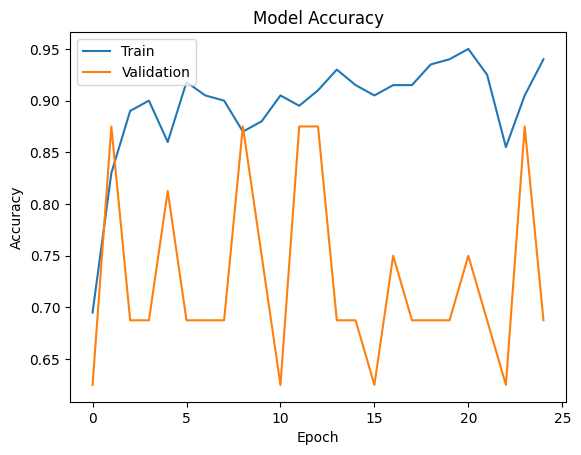

In [80]:
import matplotlib.pyplot as plt

#plots of training and Validation accuracy

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Hyperparameter Tuning

The given code presents a DenseNetHyperModel class that allows for the specification of hyperparameters such as the number of units in the dense layers and the type of optimizer.

In [71]:
%pip install optuna


Note: you may need to restart the kernel to use updated packages.


In [72]:
%pip install tqdm
from tqdm import tqdm


Note: you may need to restart the kernel to use updated packages.


In [75]:
import optuna
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def Object(trial):
    #defining the hyperparameters to be tuned
    dense_units = trial.suggest_categorical('dense_units', [128,256,512])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    #building the model
    Base_model = DenseNet121(include_top=False, input_shape=(150,150, 3), weights='imagenet')
    Base_model.trainable = False #freezing the base model

    x = Base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_units, activation='relu')(x)
    predict = Dense(1, activation='sigmoid')(x)

    model = Model(inputs= Base_model.input, outputs=predict)

    # compiling the model

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    

    #fiting the model
    history = model.fit(train_Gen, epochs=10, validation_data=valid_Gen)

    #getting the best validation accuracy
    best_accur = max(history.history['val_accuracy'])
    return best_accur
    

In [76]:
"""Creating an Optuna study and starting Optimization"""

opt_study = optuna.create_study(direction='maximize')
opt_study.optimize(Object, n_trials=10)

print('Number of Finished trials:' , len(opt_study.trials))
print('Best trial:')
trial = opt_study.best_trial

print('   Value: ', trial.value)
print(' Params: ')
for k, val in trial.params.items():
    print(f'    {k}: {val}')



[I 2024-03-19 01:23:37,802] A new study created in memory with name: no-name-1a25c55d-8982-470c-8c2c-2690e1e3c7cc
C:\Users\Ananya\AppData\Local\Temp\ipykernel_49872\3010648853.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 134s 464ms/step - accuracy: 0.8417 - loss: 0.4818 - val_accuracy: 0.8750 - val_loss: 0.2169
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 120s 453ms/step - accuracy: 0.9197 - loss: 0.1980 - val_accuracy: 0.8750 - val_loss: 0.2349
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 119s 449ms/step - accuracy: 0.9244 - loss: 0.1740 - val_accuracy: 0.8750 - val_loss: 0.3624
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 115s 435ms/step - accuracy: 0.9347 - loss: 0.1629 - val_accuracy: 0.8750 - val_loss: 0.3882
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 120s 453ms/step - accuracy: 0.9258 - loss: 0.1792 - val_accuracy: 0.8750 - val_loss: 0.4721
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 118s 447ms/step - accuracy: 0.9342 - loss: 0.1564 - val_accuracy: 0.8125 - val_loss: 0.5426
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 118s 447ms/step - accuracy: 0.9296 - loss: 0.1689 - val_accuracy: 0.8750 - val_loss: 0.3972
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 115s 433ms/step - accuracy: 0.9307 -

[I 2024-03-19 01:43:34,290] Trial 0 finished with value: 0.875 and parameters: {'dense_units': 256, 'learning_rate': 0.0033069168967849684}. Best is trial 0 with value: 0.875.


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 131s 440ms/step - accuracy: 0.8540 - loss: 0.3512 - val_accuracy: 0.8750 - val_loss: 0.3379
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 108s 409ms/step - accuracy: 0.9220 - loss: 0.1981 - val_accuracy: 0.8750 - val_loss: 0.2397
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 108s 407ms/step - accuracy: 0.9255 - loss: 0.2013 - val_accuracy: 0.8125 - val_loss: 0.5620
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 108s 407ms/step - accuracy: 0.9192 - loss: 0.1965 - val_accuracy: 0.8125 - val_loss: 0.4668
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 116s 438ms/step - accuracy: 0.9364 - loss: 0.1602 - val_accuracy: 0.8750 - val_loss: 0.2485
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 109s 413ms/step - accuracy: 0.9403 - loss: 0.1508 - val_accuracy: 0.8125 - val_loss: 0.2866
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 115s 434ms/step - accuracy: 0.9344 - loss: 0.1657 - val_accuracy: 0.7500 - val_loss: 0.4616
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 115s 435ms/step - accuracy: 0.9367 -

[I 2024-03-19 02:02:37,603] Trial 1 finished with value: 0.875 and parameters: {'dense_units': 256, 'learning_rate': 0.0009151069961019843}. Best is trial 0 with value: 0.875.


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 131s 455ms/step - accuracy: 0.8580 - loss: 0.3177 - val_accuracy: 0.8750 - val_loss: 0.2517
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 117s 441ms/step - accuracy: 0.9277 - loss: 0.1877 - val_accuracy: 0.8750 - val_loss: 0.3035
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 116s 439ms/step - accuracy: 0.9323 - loss: 0.1716 - val_accuracy: 0.8750 - val_loss: 0.5126
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 115s 433ms/step - accuracy: 0.9231 - loss: 0.1834 - val_accuracy: 0.8125 - val_loss: 0.5953
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 116s 437ms/step - accuracy: 0.9343 - loss: 0.1632 - val_accuracy: 0.8125 - val_loss: 0.5969
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 107s 405ms/step - accuracy: 0.9290 - loss: 0.1747 - val_accuracy: 0.8750 - val_loss: 0.4701
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 107s 405ms/step - accuracy: 0.9367 - loss: 0.1632 - val_accuracy: 0.8750 - val_loss: 0.3648
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 106s 402ms/step - accuracy: 0.9448 -

[I 2024-03-19 02:21:30,495] Trial 2 finished with value: 0.875 and parameters: {'dense_units': 128, 'learning_rate': 0.00027186853281055157}. Best is trial 0 with value: 0.875.


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 123s 426ms/step - accuracy: 0.8363 - loss: 0.3555 - val_accuracy: 0.8750 - val_loss: 0.3077
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 110s 416ms/step - accuracy: 0.9207 - loss: 0.1901 - val_accuracy: 0.6875 - val_loss: 0.6717
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 112s 421ms/step - accuracy: 0.9298 - loss: 0.1743 - val_accuracy: 0.8750 - val_loss: 0.3892
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 111s 420ms/step - accuracy: 0.9270 - loss: 0.1792 - val_accuracy: 0.8750 - val_loss: 0.3446
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 113s 426ms/step - accuracy: 0.9282 - loss: 0.1698 - val_accuracy: 0.8750 - val_loss: 0.5072
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 111s 421ms/step - accuracy: 0.9461 - loss: 0.1429 - val_accuracy: 0.8750 - val_loss: 0.3969
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 112s 424ms/step - accuracy: 0.9388 - loss: 0.1599 - val_accuracy: 0.8125 - val_loss: 0.6439
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 111s 419ms/step - accuracy: 0.9438 -

[I 2024-03-19 02:40:18,328] Trial 3 finished with value: 0.875 and parameters: {'dense_units': 256, 'learning_rate': 0.00020860425646147894}. Best is trial 0 with value: 0.875.


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 127s 441ms/step - accuracy: 0.8537 - loss: 0.3548 - val_accuracy: 0.8750 - val_loss: 0.3133
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 113s 426ms/step - accuracy: 0.9197 - loss: 0.2020 - val_accuracy: 0.8750 - val_loss: 0.2740
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 111s 419ms/step - accuracy: 0.9305 - loss: 0.1783 - val_accuracy: 0.8750 - val_loss: 0.2411
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 119s 450ms/step - accuracy: 0.9341 - loss: 0.1688 - val_accuracy: 0.8125 - val_loss: 0.5267
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 123s 464ms/step - accuracy: 0.9321 - loss: 0.1636 - val_accuracy: 0.8750 - val_loss: 0.4245
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 120s 455ms/step - accuracy: 0.9425 - loss: 0.1480 - val_accuracy: 0.8750 - val_loss: 0.3704
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 120s 453ms/step - accuracy: 0.9389 - loss: 0.1647 - val_accuracy: 0.8750 - val_loss: 0.2740
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 120s 454ms/step - accuracy: 0.9361 -

[I 2024-03-19 03:00:17,307] Trial 4 finished with value: 0.875 and parameters: {'dense_units': 256, 'learning_rate': 0.00026422701666206617}. Best is trial 0 with value: 0.875.


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 134s 464ms/step - accuracy: 0.8342 - loss: 0.4432 - val_accuracy: 0.8125 - val_loss: 0.6633
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 119s 451ms/step - accuracy: 0.9111 - loss: 0.2109 - val_accuracy: 0.8750 - val_loss: 0.3240
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 113s 426ms/step - accuracy: 0.9286 - loss: 0.1860 - val_accuracy: 0.8750 - val_loss: 0.3554
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 110s 414ms/step - accuracy: 0.9269 - loss: 0.1802 - val_accuracy: 0.8750 - val_loss: 0.3722
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 110s 414ms/step - accuracy: 0.9404 - loss: 0.1608 - val_accuracy: 0.8750 - val_loss: 0.2952
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 110s 416ms/step - accuracy: 0.9315 - loss: 0.1622 - val_accuracy: 0.8750 - val_loss: 0.3634
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 111s 421ms/step - accuracy: 0.9313 - loss: 0.1606 - val_accuracy: 0.8125 - val_loss: 0.3728
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 109s 411ms/step - accuracy: 0.9282 -

[I 2024-03-19 03:19:12,936] Trial 5 finished with value: 0.875 and parameters: {'dense_units': 128, 'learning_rate': 0.0017132056311716592}. Best is trial 0 with value: 0.875.


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 136s 472ms/step - accuracy: 0.8486 - loss: 0.3641 - val_accuracy: 0.8125 - val_loss: 0.5391
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 122s 460ms/step - accuracy: 0.9276 - loss: 0.1877 - val_accuracy: 0.8750 - val_loss: 0.6579
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 129s 488ms/step - accuracy: 0.9133 - loss: 0.2156 - val_accuracy: 0.8125 - val_loss: 0.6046
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 133s 503ms/step - accuracy: 0.9243 - loss: 0.1834 - val_accuracy: 0.8750 - val_loss: 0.4661
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 135s 510ms/step - accuracy: 0.9326 - loss: 0.1726 - val_accuracy: 0.8750 - val_loss: 0.5232
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 132s 499ms/step - accuracy: 0.9342 - loss: 0.1718 - val_accuracy: 0.8750 - val_loss: 0.4913
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 134s 505ms/step - accuracy: 0.9430 - loss: 0.1427 - val_accuracy: 0.8750 - val_loss: 0.4477
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 136s 513ms/step - accuracy: 0.9280 -

[I 2024-03-19 03:41:20,839] Trial 6 finished with value: 0.875 and parameters: {'dense_units': 256, 'learning_rate': 0.0006650805307568292}. Best is trial 0 with value: 0.875.


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 151s 526ms/step - accuracy: 0.8672 - loss: 0.3036 - val_accuracy: 0.6875 - val_loss: 0.6474
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 134s 507ms/step - accuracy: 0.9262 - loss: 0.1925 - val_accuracy: 0.8750 - val_loss: 0.4663
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 134s 508ms/step - accuracy: 0.9343 - loss: 0.1691 - val_accuracy: 0.8750 - val_loss: 0.3151
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 130s 491ms/step - accuracy: 0.9424 - loss: 0.1619 - val_accuracy: 0.8125 - val_loss: 0.2791
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 132s 499ms/step - accuracy: 0.9314 - loss: 0.1761 - val_accuracy: 0.8750 - val_loss: 0.4086
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 134s 506ms/step - accuracy: 0.9367 - loss: 0.1622 - val_accuracy: 0.8125 - val_loss: 0.2674
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 125s 473ms/step - accuracy: 0.9469 - loss: 0.1404 - val_accuracy: 0.8750 - val_loss: 0.4165
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 125s 472ms/step - accuracy: 0.9406 -

[I 2024-03-19 04:03:20,161] Trial 7 finished with value: 0.875 and parameters: {'dense_units': 512, 'learning_rate': 0.00019372068828701786}. Best is trial 0 with value: 0.875.


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 146s 510ms/step - accuracy: 0.8395 - loss: 0.9586 - val_accuracy: 0.6875 - val_loss: 0.9577
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 129s 486ms/step - accuracy: 0.9120 - loss: 0.1984 - val_accuracy: 0.8125 - val_loss: 0.2802
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 128s 484ms/step - accuracy: 0.9309 - loss: 0.1878 - val_accuracy: 0.8750 - val_loss: 0.3170
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 128s 483ms/step - accuracy: 0.9278 - loss: 0.1788 - val_accuracy: 0.7500 - val_loss: 0.6078
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 128s 483ms/step - accuracy: 0.9319 - loss: 0.1668 - val_accuracy: 0.8750 - val_loss: 0.4907
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 128s 483ms/step - accuracy: 0.9305 - loss: 0.1733 - val_accuracy: 0.7500 - val_loss: 0.8537
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 128s 484ms/step - accuracy: 0.9223 - loss: 0.1879 - val_accuracy: 0.8750 - val_loss: 0.3335
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 128s 483ms/step - accuracy: 0.9356 -

[I 2024-03-19 04:24:59,160] Trial 8 finished with value: 0.875 and parameters: {'dense_units': 512, 'learning_rate': 0.007504119873389431}. Best is trial 0 with value: 0.875.


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 142s 494ms/step - accuracy: 0.8444 - loss: 0.3888 - val_accuracy: 0.5625 - val_loss: 1.5805
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 125s 473ms/step - accuracy: 0.9016 - loss: 0.2464 - val_accuracy: 0.8750 - val_loss: 0.4768
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 126s 475ms/step - accuracy: 0.9278 - loss: 0.1856 - val_accuracy: 0.8750 - val_loss: 0.4282
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 125s 472ms/step - accuracy: 0.9237 - loss: 0.1860 - val_accuracy: 0.8750 - val_loss: 0.4792
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 126s 474ms/step - accuracy: 0.9345 - loss: 0.1699 - val_accuracy: 0.8750 - val_loss: 0.4061
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 125s 473ms/step - accuracy: 0.9330 - loss: 0.1648 - val_accuracy: 0.8125 - val_loss: 0.4487
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 125s 472ms/step - accuracy: 0.9386 - loss: 0.1620 - val_accuracy: 0.7500 - val_loss: 0.8303
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 125s 471ms/step - accuracy: 0.9385 -

[I 2024-03-19 04:46:08,932] Trial 9 finished with value: 0.875 and parameters: {'dense_units': 512, 'learning_rate': 0.0006264510570551983}. Best is trial 0 with value: 0.875.


Number of Finished trials: 10
Best trial:
   Value:  0.875
 Params: 
    dense_units: 256
    learning_rate: 0.0033069168967849684


## Evaluate and Predict with Original Model


In [81]:
# make prediction
base_prediction = dense_base_model.predict(test_Gen)
base_binary_predict = (base_prediction>0.5).astype(int)

c:\Users\Ananya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 575ms/step


In [82]:
# Evaluating the model

base_eval = dense_base_model.evaluate(test_Gen)
print(f"Base Model - Accuracy:  {base_eval[1]} Loss:  {base_eval[0]}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - accuracy: 0.7917 - loss: 0.5317
Base Model - Accuracy:  0.8044871687889099 Loss:  0.5102853775024414


In [92]:
%pip install plotly

In [95]:
import sys
print(sys.executable)


c:\Users\Ananya\AppData\Local\Programs\Python\Python311\python.exe


In [96]:
import plotly
print(plotly.__version__)


5.20.0


In [98]:
%pip uninstall plotly
%pip install plotly


^C
Note: you may need to restart the kernel to use updated packages.



In [97]:

import optuna

from optuna.visualization import plot_optimization_history

plot_optimization_history(opt_study)


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

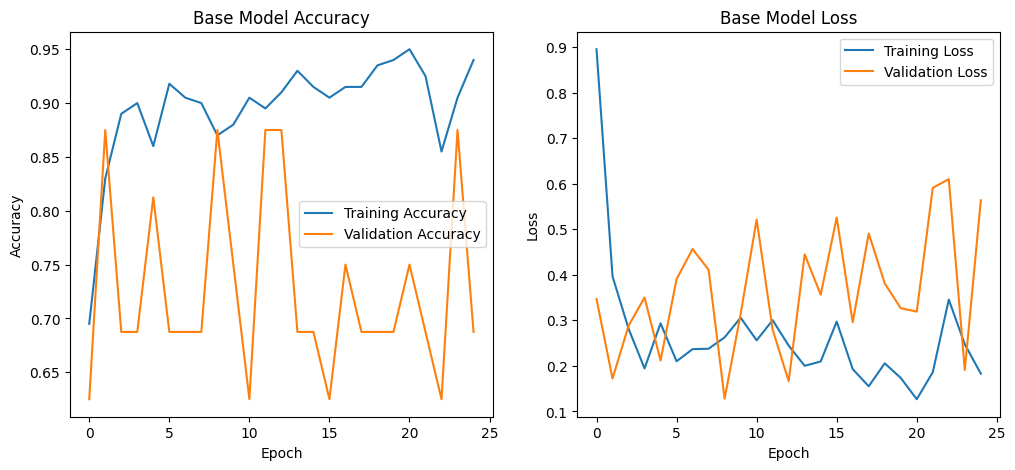

In [83]:
# visualise

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Base Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Base Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Evaluate and Predict with Hyperparameter Tuning

In [85]:
# Predict with the Tuned model

tuned_prediction = model.predict(test_Gen)
tuned_binary_predict = (tuned_prediction > 0.5).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step


In [86]:
# Evalute the tuned model

tuned_eval = model.evaluate(test_Gen)
print(f"Tuned Model - Accuracy: {tuned_eval[1]} Loss: {tuned_eval[0]}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 465ms/step - accuracy: 0.8636 - loss: 0.3363
Tuned Model - Accuracy: 0.875 Loss: 0.3211361765861511


NameError: name 'history' is not defined

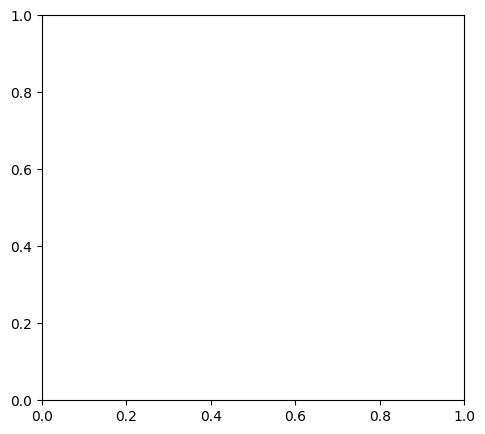

In [87]:
# Visualize tunned

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Tuned Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Tuned Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [ ]:
REMOVE STUFF FROM HERE

In [21]:
%pip install keras-tuner

In [35]:
%pip install -U keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [41]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [42]:

from tensorflow.keras.applications import DenseNet121 as DN121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model



def create_hyperMod(dense_units= 256, learning_rate=0.001):
    Base_model = DN121(include_top=False, input_shape=(150,150, 3), weights='imagenet')
    Base_model.trainable = False #freezing the base model

    x = Base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_units, activation='relu')(x)
    predict = Dense(1, activation='sigmoid')(x)

    model = Model(inputs= Base_model.input, outputs=predict)
    model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'], learning_rate=learning_rate)
    
    return model


   

In [49]:
import tensorflow as tf
print(tf.__version__)

#import tensorflow as tf
#print(tf.__version__)  # Make sure it prints 2.16.1 or whatever version you're using

# Simple test to check if TensorFlow is working
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(train_images.shape)  # Just to verify data loading


2.16.1
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
(60000, 28, 28)


In [47]:
%pip install --upgrade tensorflow


Note: you may need to restart the kernel to use updated packages.


In [52]:
# wrapping the Model function with keras classifier

#from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier




ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [ ]:
model = KerasClassifier(build_fn=create_hyperMod, epochs=10, batch_size=32)

### Performing hyperparameter search

This code employs the RandomSearch algorithm to systematically examine various hyperparameter configurations in order to identify the optimal model based on validation accuracy.

In [38]:
#from keras_tuner import RandomSearch as RanSrch

#creating an instance of HyperModel class
hypermodel = DenseNetHyper_Model(input_shape=(150, 150, 3))

In [40]:
from keras_tuner import RandomSearch

tuner = RandomSearch(hypermodel, objective='val_accuracy', max_trials= 10, executions_per_trial= 1, directory= 'hyper_search_results', project_name='keras_tuner_dense')

tuner.search(train_Gen, validation_data= valid_Gen, epochs=10)


NotImplementedError: 